# Dollar-Cost Averaging vs. Buy-and-Hold
Over the past two weeks, I wrote about some practical financial-related issues: choosing a mobile phone plan and optimising your bank account. These topics got me interested in financial management. I revisited some investing strategies that I considered over the years and chose one to analyse in greater depth: dollar-cost averaging (DCA). In this post, I investigate the returns from using DCA to invest in the Straits Times Index (STI), and compare it against a simple buy-and-hold strategy.

In [1]:
# Import required modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as ss
import seaborn.apionly as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# Dollar-Cost Averaging?
Dollar-cost averaging (DCA) is a simplistic technique for investing in the stock market. It involves investing a fixed dollar amount, like \$100, at intervals during a period of time. [POSB's Invest-Saver](https://www.posb.com.sg/personal/investments/investing-in-funds/invest-saver) provides you with the ability to do just that: you can set a fixed amount to invest every month, and POSB will put that money into the Nikko AM STI Exchange-Traded Fund (ETF) on a monthly basis.  
  
DCA sounds simple enough. However, is the simplicity worth your money? The alternative, which is on the far end of the spectrum in terms of the number of trades but is equally simple, is the buy-and-hold strategy. The idea is to buy an index and hold it over the long term.  
  
In this post, we compare the returns from DCA and buy-and-hold using simulations.

# Simulation Strategy
My objective is to get a large number of possible outcomes from using DCA and buy-and-hold on the STI over a long time frame. This will give us two **distributions** of returns - one each for DCA and one for buy-and-hold. We can then compare them to decide which is the better strategy. For the purposes of this study, let's define a "large number" as 10,000, and a "long time frame" as 10 years.  
  
## The STI
We need to simulate 10,000 runs of the STI over a period of 10 years. Conceptually, we can think of it as 10,000 parallel universes where the STI in each one moves in a different, random way from all others. To do so, we use the historical distribution of monthly STI data to draw 120 random "monthly returns" per run. Thus, we need to fit a probability distribution to the monthly returns. From the graph below, it appears that the appropriate distribution to fit to the data is a normal distribution.  

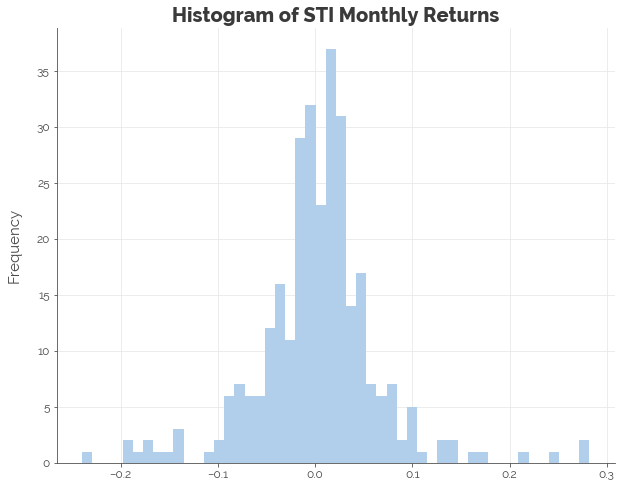

In [3]:
# Import Straits Times Index data
sti = pd.read_csv('sti.csv')

# Convert date format
sti.Date = sti.Date.astype('datetime64')

# Compute monthly returns
sti['returns'] = sti.Close.pct_change(1)

# Remove missing entries
sti.dropna(axis = 0, inplace = True)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

In the graphs below, the orange line represents the density of the true monthly returns, while the dark blue line represents the density of the fitted distribution. We see that the fitted distribution is far from perfect. It implies more gains and losses of approximately 7.5% to 10% than history suggests, fewer gains and losses of 20% and beyond, and way fewer uneventful months. To obtain a distribution that allows us to better model the "normal" economy, I scale the standard deviation by 75% until the central part of the fitted density resembled the historical density.

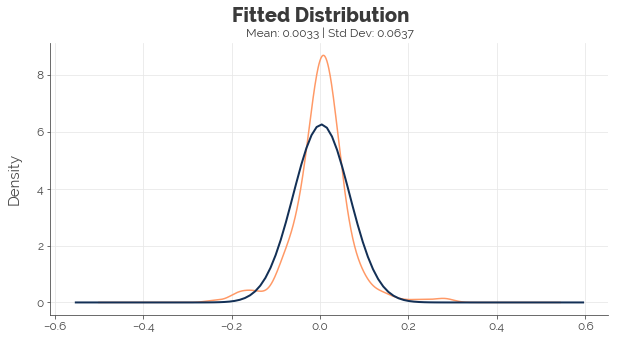

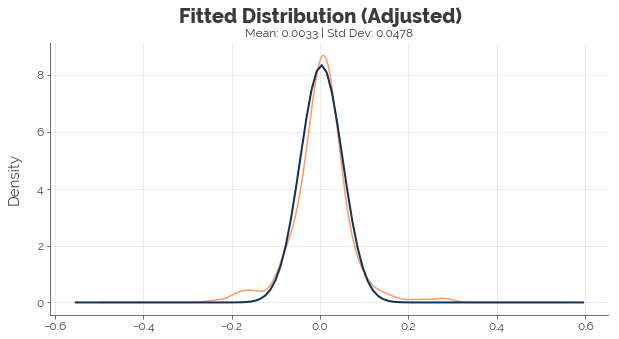

In [4]:
# Fit a normal distribution to monthly returns
mu, std = ss.norm.fit(sti.returns)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

# Adjust standard deviation
std_new = std * 0.75

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

## Simulation: DCA vs. Buy-and-hold
Now, we run 10,000 simulations of DCA and buy-and-hold with the following assumptions:  
  
* Contribution of \$100 a month for 10 years (120 months)
* Starting STI price of \$3.124
* Dividends of 2.00% are paid annually and **not** reinvested
  

In [5]:
# Configure no. of simulations
SIMULATIONS = 10000
DCA_SPEND = 100
DCA_INVEST = 99
BAH_SPEND = DCA_SPEND * 120
BAH_INVEST = DCA_INVEST * 120
CURRENT_STI_PRICE = 3.124

# Initialise data frame for results
dca = pd.DataFrame()
bah = pd.DataFrame()

# Initialise simulation names
sim_names = ['sim' + str(x) for x in range(SIMULATIONS)]

# Perform independent simulations
np.random.seed(1)
for k in range(SIMULATIONS):
    
    # Simulate 10 years of stock price progression using monthly returns
    stock_returns = np.cumproduct(1 + np.array([0] + list(ss.norm.rvs(mu, std_new, 119))))
    stock_prices = stock_returns * CURRENT_STI_PRICE
    
    # Calculate number of stocks in portfolio from investing INVEST_AMT each month
    stock_amts = np.cumsum(DCA_INVEST / stock_prices)
    
    # Calculate portfolio values
    dca_values = stock_amts * stock_prices * 1.02
    bah_values = stock_returns * BAH_INVEST * 1.02

    # Append to results data frame
    dca['sim' + str(k)] = dca_values
    bah['sim' + str(k)] = bah_values

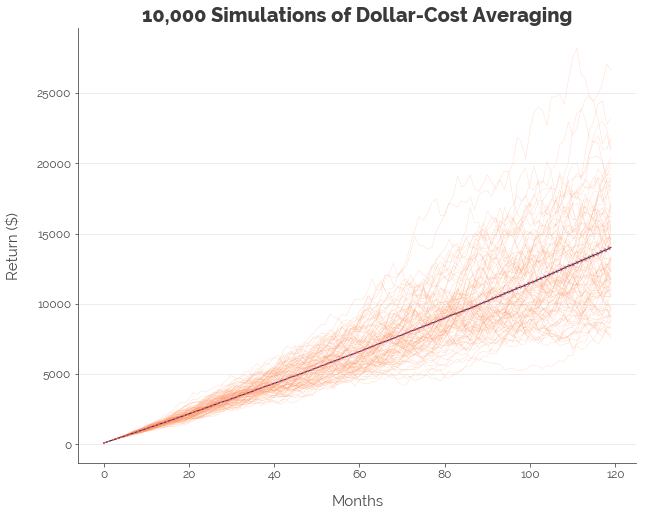

[-- RESULTS OF DCA --]
Upper   : 1.75%
Mean    : 1.69%
Lower   : 1.63%


In [6]:
# Calculate statistics
dca['means'] = dca[sim_names].mean(axis = 1)
dca['medians'] = dca[sim_names].median(axis = 1)
dca['sd'] = dca[sim_names].std(axis = 1)
dca['lower_ci'] = dca.medians - 1.96 * dca.sd / np.sqrt(SIMULATIONS)
dca['upper_ci'] = dca.medians + 1.96 * dca.sd / np.sqrt(SIMULATIONS)

# Shortlist simulations with less than $25,000 ending sum - for plotting purposes only
random.seed(123)
plot_sims = random.sample(list(dca[sim_names].columns), 100)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

# Function to calculate annualised return
def calc_annret(x, principal):
    
    return ((x / principal) ** (1/10) - 1)*100

# Calculate annualised returns
ann_rets = calc_annret(dca[sim_names].iloc[-1], 120*DCA_SPEND)

# Calculate statistics
ret_mean = np.mean(ann_rets)
ret_std = np.std(ann_rets)
ret_lower_ci = ret_mean - ret_std * 1.96 / np.sqrt(10000)
ret_upper_ci = ret_mean + ret_std * 1.96 / np.sqrt(10000)

# Print
print('[-- RESULTS OF DCA --]')
print('Upper   : ' + str(round(ret_upper_ci, 2)) + '%')
print('Mean    : ' + str(round(ret_mean, 2)) + '%')
print('Lower   : ' + str(round(ret_lower_ci, 2)) + '%')

In the graph above, the orange lines represent 100 of the 10,000 random runs of the STI. The blue line represents the mean portfolio value at each point in time. The dotted red lines above and below the blue line (barely visible) jointly represent the 95% confidence interval of portfolio value at each point in time. The graphs are plotted with the exact same features and colours.  
  
Now, plotting the same graph and calculate the same statistics for the buy-and-hold strategy:

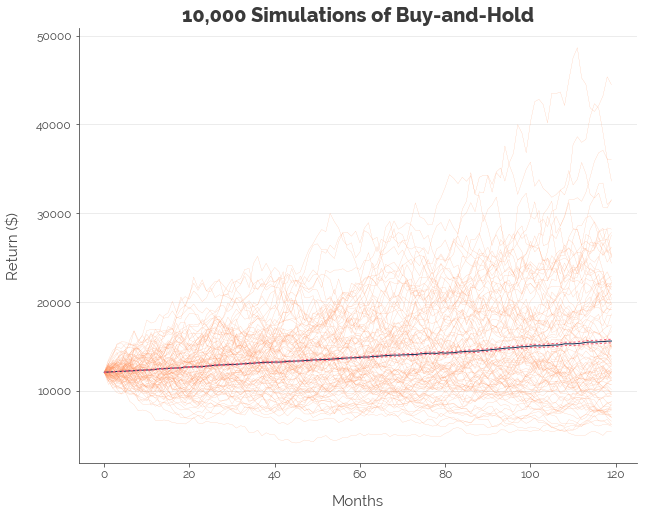

[-- RESULTS OF BUY-AND-HOLD --]
Upper   : 2.93%
Mean    : 2.82%
Lower   : 2.72%


In [7]:
# Calculate statistics
bah['means'] = bah[sim_names].mean(axis = 1)
bah['medians'] = bah[sim_names].median(axis = 1)
bah['sd'] = bah[sim_names].std(axis = 1)
bah['lower_ci'] = bah.medians - 1.96 * bah.sd / np.sqrt(SIMULATIONS)
bah['upper_ci'] = bah.medians + 1.96 * bah.sd / np.sqrt(SIMULATIONS)

# Shortlist simulations with less than $25,000 ending sum - for plotting purposes only
random.seed(123)
plot_sims = random.sample(list(bah[sim_names].columns), 100)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

# Calculate annualised returns
ann_rets = calc_annret(bah[sim_names].iloc[-1], BAH_SPEND)

# Calculate statistics
ret_mean = np.mean(ann_rets)
ret_std = np.std(ann_rets)
ret_lower_ci = ret_mean - ret_std * 1.96 / np.sqrt(10000)
ret_upper_ci = ret_mean + ret_std * 1.96 / np.sqrt(10000)

# Print
print('[-- RESULTS OF BUY-AND-HOLD --]')
print('Upper   : ' + str(round(ret_upper_ci, 2)) + '%')
print('Mean    : ' + str(round(ret_mean, 2)) + '%')
print('Lower   : ' + str(round(ret_lower_ci, 2)) + '%')

### Summary on DCA vs. Buy-and-Hold Simulation
The results are summarised in the table below:  
  
|  Strategy             | Mean Annual Returns | 95% CI        | SD of Outcomes |
|-----------------------|---------------------|---------------|-----------|
| Dollar-Cost Averaging | 1.69%               | 1.63% - 1.75% | 3.14%     |
| Buy-and-Hold          | 2.82%               | 2.72% - 2.93% | 5.38%     |   
  
Clearly, buy-and-hold is the wiser choice. Note that the standard deviation (SD) in the table represents volatility across the separate simulations. It suggests that DCA will produce more similar results under random conditions. **It does not imply lower volatility**, because the underlying asset in both strategies was the same (the STI).

## Simulation: DCA vs. Buy-and-Hold with Lower Costs
In the earlier simulations, we assumed that we invested \$100 a month with a fee of \$1.00 per transaction. However, costs would be different if we invested a larger sum because banks charge a lower commission for bigger trades. To measure the effect of transaction costs, we run the simulation again, assuming that we invest \$6,000 a month for DCA instead. The transaction fee is \$10.27, which amounts to 0.17%. This figure of \$10.27 is not arbitrary. It is the actual transaction cost from a trade worth \$6,000 executed through a DBS Vickers Cash Upfront trading account: Singapore's only cash account that enables you to **retain ownership of the assets you purchase** while providing the lowest trading fees.

In [8]:
# Configure no. of simulations
SIMULATIONS = 10000
DCA_SPEND = 6000
DCA_INVEST = 6000-10.27
BAH_SPEND = DCA_SPEND * 120
BAH_INVEST = DCA_INVEST * 120
CURRENT_STI_PRICE = 3.124

# Initialise data frame for results
dca = pd.DataFrame()
bah = pd.DataFrame()

# Initialise simulation names
sim_names = ['sim' + str(x) for x in range(SIMULATIONS)]

# Perform independent simulations
np.random.seed(1)
for k in range(SIMULATIONS):
    
    # Simulate 10 years of stock price progression using monthly returns
    stock_returns = np.cumproduct(1 + np.array([0] + list(ss.norm.rvs(mu, std_new, 119))))
    stock_prices = stock_returns * CURRENT_STI_PRICE
    
    # Calculate number of stocks in portfolio from investing INVEST_AMT each month
    stock_amts = np.cumsum(DCA_INVEST / stock_prices)
    
    # Calculate portfolio values
    dca_values = stock_amts * stock_prices * 1.02
    bah_values = stock_returns * BAH_INVEST * 1.02

    # Append to results data frame
    dca['sim' + str(k)] = dca_values
    bah['sim' + str(k)] = bah_values

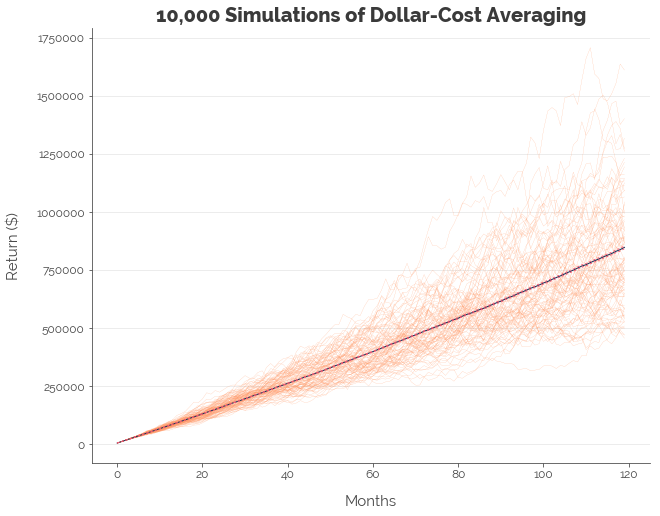

[-- RESULTS OF DCA --]
Upper   : 1.84%
Mean    : 1.78%
Lower   : 1.71%


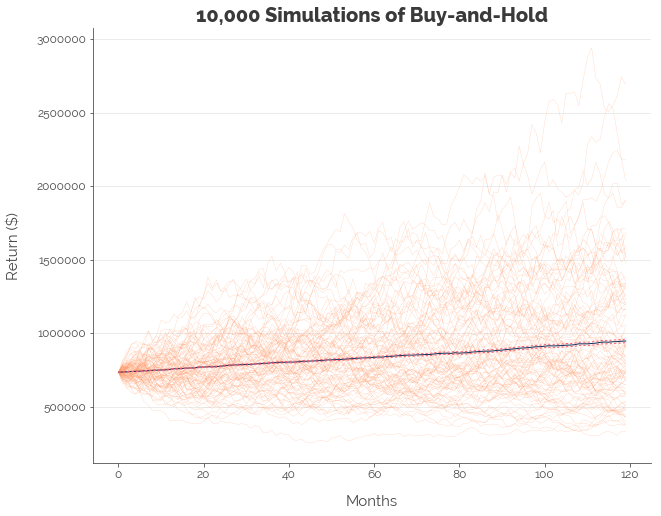

[-- RESULTS OF BUY-AND-HOLD --]
Upper   : 3.01%
Mean    : 2.91%
Lower   : 2.8%


In [9]:
# Calculate statistics
dca['means'] = dca[sim_names].mean(axis = 1)
dca['medians'] = dca[sim_names].median(axis = 1)
dca['sd'] = dca[sim_names].std(axis = 1)
dca['lower_ci'] = dca.medians - 1.96 * dca.sd / np.sqrt(SIMULATIONS)
dca['upper_ci'] = dca.medians + 1.96 * dca.sd / np.sqrt(SIMULATIONS)

# Shortlist simulations with less than $25,000 ending sum - for plotting purposes only
random.seed(123)
plot_sims = random.sample(list(dca[sim_names].columns), 100)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

# Function to calculate annualised return
def calc_annret(x, principal):
    
    return ((x / principal) ** (1/10) - 1)*100

# Calculate annualised returns
ann_rets = calc_annret(dca[sim_names].iloc[-1], 120*DCA_SPEND)

# Calculate statistics
ret_mean = np.mean(ann_rets)
ret_std = np.std(ann_rets)
ret_lower_ci = ret_mean - ret_std * 1.96 / np.sqrt(10000)
ret_upper_ci = ret_mean + ret_std * 1.96 / np.sqrt(10000)

# Print
print('[-- RESULTS OF DCA --]')
print('Upper   : ' + str(round(ret_upper_ci, 2)) + '%')
print('Mean    : ' + str(round(ret_mean, 2)) + '%')
print('Lower   : ' + str(round(ret_lower_ci, 2)) + '%')

# Calculate statistics
bah['means'] = bah[sim_names].mean(axis = 1)
bah['medians'] = bah[sim_names].median(axis = 1)
bah['sd'] = bah[sim_names].std(axis = 1)
bah['lower_ci'] = bah.medians - 1.96 * bah.sd / np.sqrt(SIMULATIONS)
bah['upper_ci'] = bah.medians + 1.96 * bah.sd / np.sqrt(SIMULATIONS)

# Shortlist simulations with less than $25,000 ending sum - for plotting purposes only
random.seed(123)
plot_sims = random.sample(list(bah[sim_names].columns), 100)

# CODE FOR CUSTOM GRAPHICS NOT INCLUDED

# Calculate annualised returns
ann_rets = calc_annret(bah[sim_names].iloc[-1], BAH_SPEND)

# Calculate statistics
ret_mean = np.mean(ann_rets)
ret_std = np.std(ann_rets)
ret_lower_ci = ret_mean - ret_std * 1.96 / np.sqrt(10000)
ret_upper_ci = ret_mean + ret_std * 1.96 / np.sqrt(10000)

# Print
print('[-- RESULTS OF BUY-AND-HOLD --]')
print('Upper   : ' + str(round(ret_upper_ci, 2)) + '%')
print('Mean    : ' + str(round(ret_mean, 2)) + '%')
print('Lower   : ' + str(round(ret_lower_ci, 2)) + '%')

## Summary on Low-Cost DCA vs. Buy-and-Hold Simulation
The results are summarised in the table below:  
  
|  Strategy             | Transaction Costs | Mean Annual Returns | 95% CI        | SD of Outcomes |
|-----------------------|-------------------|---------------------|---------------|-----------|
| Dollar-Cost Averaging | High              | 1.69%               | 1.63% - 1.75% | 3.14%     |
| Dollar-Cost Averaging | Low               | 1.78%               | 1.71% - 1.84% | 3.14%     |
| Buy-and-Hold          | High              | 2.82%               | 2.72% - 2.93% | 5.38%     |
| Buy-and-Hold          | Low               | 2.91%               | 2.80% - 3.01% | 5.38%     |   
  
The difference in the mean annualised return for the low-cost and "high-cost" trading strategies for both DCA and buy-and-hold was 0.09%.  which translates to a difference of **0.10% per annum after compounding**. It might not sound like a lot, but, 0.10% is approximately **twice** the base interest on most Singapore bank accounts. This tells us that investing a bigger sum to cut transaction costs has a relatively big impact on our returns.  

# Conclusion [TLDR]
  
### Go for Buy-and-Hold
It is clear: the buy-and-hold strategy delivers higher returns. Hence, don't bother investing in the POSB Invest-Saver. Just open a stock trading account and buy the Nikko AM STI ETF yourself.  
  
### Invest a Lump Sum
Executing one big trade is much more worthwhile than executing many smaller ones. This is because you avoid racking up a large sum in transaction costs that chip away at your profits.
  
### Optimise Your Savings
Note how the mean annualised returns of 2.91% per annum (without dividend reinvestment) for the lump sum buy-and-hold strategy are similar to the returns guaranteed on a MayBank SaveUp account. Although the SaveUp account removes the possibility of earning a fortune if you're lucky, it also insulates you against losing a fortune if you're not so lucky. As a highly risk-averse investor, I would pick the more certain option: MayBank, and the associated shoe-leather costs of maintaining the transactions.